### Imports

In [1]:
from src.preprocessing.interpolation import HandKeypointInterpolator # Clase de interpolación
from src.preprocessing.data_augmentation import DataAugmentor  # Clase de interpolación
from src.preprocessing.normalization import LandmarkNormalizer  # Asegúrate de importar correctamente esta clase
from src.utils.utils import generate_landmarks_comparison_video
import zarr
import numpy as np
from tqdm import tqdm
from numcodecs import Blosc, Pickle
import matplotlib.pyplot as plt

2025-02-05 10:22:33.806238: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-05 10:22:33.829989: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-05 10:22:34.191596: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Dataset Creation

In [2]:
import fasttext
import fasttext.util
import json

# Inicializar modelo FastText
ft = fasttext.load_model("cc.en.300.bin")  # Asegúrate de usar el archivo correcto

# Rutas de archivos
landmarks_path = "data/dataset/mutemotion/archive/landmarks_V2.zarr"
labels_path = "data/dataset/mutemotion/archive/WLASL_parsed_data.json"

# Cargar landmarks en formato Zarr
landmarks_data = zarr.open_group(landmarks_path, mode="r")

# Cargar labels desde JSON
with open(labels_path, 'r') as file:
    data = json.load(file)

# Asignar landmarks y embeddings a los splits
splits = {"train": [], "val": [], "test": []}
word_to_embedding = {}  # Diccionario para almacenar los embeddings únicos por palabra

for idx, entry in enumerate(data):
    key = str(idx)  # Convertir índice a cadena para coincidir con las claves en Zarr
    if key in landmarks_data:
        split = entry["split"]
        gloss = entry["gloss"]
        landmark = landmarks_data[key][...]  # Acceder al array completo

        # Eliminar la coordenada z para validación y test
        if split in ["val", "test"]:
            landmark = landmark[:, :, :2]  # Mantener solo x e y (frames, num_landmarks, 2)

        # Generar el embedding para el gloss si aún no se ha generado
        if gloss not in word_to_embedding:
            word_to_embedding[gloss] = ft.get_word_vector(gloss).astype("float32")

        embedding = word_to_embedding[gloss]  # Obtener el embedding correspondiente
        splits[split].append((landmark.astype("float32"), embedding, gloss))
    else:
        print(f"Clave {key} no encontrada en Zarr.")

# Verificar los splits
for split_name, split_data in splits.items():
    print(f"Split {split_name}: {len(split_data)} muestras")

# Crear y guardar datos por split
for split_name, split_data in splits.items():
    if len(split_data) == 0:
        print(f"El split {split_name} está vacío. No se generarán archivos.")
        continue

    # Crear un grupo Zarr para cada split
    zarr_path = f"{split_name}_data_v2.zarr"
    zarr_store = zarr.open_group(zarr_path, mode="w")

    # Crear grupos para landmarks, embeddings y palabras
    landmarks_store = zarr_store.create_group("landmarks")
    embeddings_store = zarr_store.create_group("embeddings")
    words_store = zarr_store.create_group("words")  # Nuevo grupo para palabras

    # Guardar landmarks, embeddings y palabras individualmente
    for i, item in enumerate(split_data):
        landmarks_store.create_dataset(
            str(i), 
            data=item[0], 
            object_codec=Pickle(), 
            compressor=Blosc(cname="zstd", clevel=5, shuffle=Blosc.SHUFFLE),
        )
        embeddings_store.create_dataset(
            str(i),
            data=item[1],
            dtype="float32",
            compressor=Blosc(cname="zstd", clevel=5, shuffle=Blosc.SHUFFLE),
        )
        words_store.create_dataset(
            str(i),
            data=item[2],
            dtype="str",  # Almacena directamente el gloss como cadena
            compressor=Blosc(cname="zstd", clevel=5, shuffle=Blosc.SHUFFLE),
        )

    print(f"Guardado {split_name}: {len(split_data)} muestras en {zarr_path}")

Split train: 14289 muestras
Split val: 3916 muestras
Split test: 2878 muestras


/home/sardina/mlenv/lib/python3.12/site-packages/zarr/storage.py:455: UserWarning: an object_codec is only needed for object arrays
  _init_array_metadata(


Guardado train: 14289 muestras en train_data_v2.zarr
Guardado val: 3916 muestras en val_data_v2.zarr
Guardado test: 2878 muestras en test_data_v2.zarr


### Landmark Indexes

In [2]:
# Configuración de índices globales
HAND_NUM = 21  # Número de landmarks por mano
POSE_NUM = 6   # Número de landmarks del cuerpo superior

local_shoulder_left_idx = 1
local_shoulder_right_idx = 0
local_head_idx = 1
local_left_eye_idx = 130
local_right_eye_idx = 131
local_wrist_left_idx = 5
local_wrist_right_idx = 4

# Cálculo de índices globales
shoulder_left_idx = HAND_NUM * 2 + local_shoulder_left_idx
shoulder_right_idx = HAND_NUM * 2 + local_shoulder_right_idx

nose_idx = HAND_NUM * 2 + POSE_NUM + local_head_idx
left_eye_idx = HAND_NUM * 2 + POSE_NUM + local_left_eye_idx
right_eye_idx = HAND_NUM * 2 + POSE_NUM + local_right_eye_idx

global_wrist_left_idx_pose = HAND_NUM * 2 + local_wrist_left_idx
global_wrist_right_idx_pose = HAND_NUM * 2 + local_wrist_right_idx

left_idx_hand = list(range(0, HAND_NUM))
right_idx_hand = list(range(HAND_NUM, HAND_NUM * 2))

### Check .zarr

In [3]:
def inspect_zarr_groups(file_path, n_frame):
    """
    Inspecciona un archivo Zarr para imprimir el tamaño de los grupos, el tamaño de una muestra y una muestra de los datos.
    
    Args:
        file_path (str): Ruta al archivo Zarr.

    Returns:
        dict: Contiene:
            - Tamaño de los grupos `landmarks`, `embeddings` y `words`.
            - Tamaño de una muestra de `landmarks` y `embeddings`.
            - Una muestra de `landmarks`, `embeddings` y `words`.
    """
    # Abre el archivo Zarr
    zarr_data = zarr.open_group(file_path, mode="r")

    # Inicializar el resultado
    result = {
        "landmarks_size": None,
        "embeddings_size": None,
        "words_size": None,
        "landmarks_sample_shape": None,
        "embeddings_sample_shape": None,
        "landmarks_sample": None,
        "embeddings_sample": None,
        "words_sample": None,
    }

    # Revisar grupos principales
    if "landmarks" in zarr_data and "embeddings" in zarr_data and "words" in zarr_data:
        landmarks_group = zarr_data["landmarks"]
        embeddings_group = zarr_data["embeddings"]
        words_group = zarr_data["words"]

        # Tamaño de los grupos
        result["landmarks_size"] = len(landmarks_group)
        result["embeddings_size"] = len(embeddings_group)
        result["words_size"] = len(words_group)

        # Tamaño de una muestra
        first_landmark_key = list(landmarks_group.keys())[n_frame]
        first_embedding_key = list(embeddings_group.keys())[n_frame]
        first_word_key = list(words_group.keys())[n_frame]

        result["landmarks_sample_shape"] = landmarks_group[first_landmark_key].shape
        result["embeddings_sample_shape"] = embeddings_group[first_embedding_key].shape

        # Obtener una muestra
        result["landmarks_sample"] = landmarks_group[first_landmark_key][:]
        result["embeddings_sample"] = embeddings_group[first_embedding_key][:]
        result["words_sample"] = words_group[first_word_key][()]  # Acceder directamente a la cadena

        # Graficar landmarks
        plt.scatter(
            result["landmarks_sample"][:, :, 0][30],
            result["landmarks_sample"][:, :, 1][30],
            s=2
        )
        plt.gca().invert_yaxis()
        plt.title("Visualización de una muestra de landmarks")
        plt.show()

        # Imprimir resultados
        print(f"Tamaño del grupo 'landmarks': {result['landmarks_size']}")
        print(f"Tamaño del grupo 'embeddings': {result['embeddings_size']}")
        print(f"Tamaño del grupo 'words': {result['words_size']}")
        print(f"Tamaño de una muestra de 'landmarks': {result['landmarks_sample_shape']}")
        print(f"Tamaño de una muestra de 'embeddings': {result['embeddings_sample_shape']}")
        #print(f"Muestra de 'landmarks':\n{result['landmarks_sample'][:5]}")  # Mostrar solo los primeros 5 frames
        print(f"Muestra de 'embeddings':\n{result['embeddings_sample'][:5]}")  # Mostrar solo los primeros 5 valores
        print(f"Muestra de 'words': {result['words_sample']}")  # Mostrar la palabra
    else:
        missing_groups = [
            group for group in ["landmarks", "embeddings", "words"] if group not in zarr_data
        ]
        raise ValueError(f"El archivo Zarr no contiene los grupos esperados: {', '.join(missing_groups)}.")

    return result

### Interpolation

In [9]:
def process_landmarks(train_data_path, output_path, interpolator, landmarks_group="landmarks"):
    """
    Procesa los landmarks interpolándolos y guardándolos en un nuevo archivo Zarr.

    Args:
        train_data_path (str): Ruta al archivo Zarr de entrada.
        output_path (str): Ruta al archivo Zarr de salida.
        interpolator (HandKeypointInterpolator): Instancia de la clase de interpolación.
        landmarks_group (str): Nombre del grupo de landmarks en el archivo Zarr.
    """
    # Cargar datos Zarr
    train_data = zarr.open_group(train_data_path, mode="r")
    landmarks = train_data[landmarks_group]

    # Crear archivo Zarr para guardar los datos interpolados
    output_data = zarr.open_group(output_path, mode="w")
    landmarks_interpolated = output_data.create_group(landmarks_group)

    # Aplicar la interpolación a cada secuencia de landmarks
    for idx in tqdm(range(len(landmarks)), desc="Interpolando secuencias", unit="secuencia"):
        frames = landmarks[str(idx)][...]  # Acceder a los landmarks
        interpolated_frames = interpolator.interpolate_hand_keypoints(frames)  # Interpolar
        landmarks_interpolated.create_dataset(
            str(idx),
            data=interpolated_frames,
            object_codec=Pickle(),
            compressor=Blosc(cname="zstd", clevel=5, shuffle=Blosc.SHUFFLE),
        )
    print(f"Landmarks interpolados guardados en: {output_path}")


def copy_embeddings(train_data_path, output_path, embeddings_group="embeddings"):
    """
    Copia los embeddings directamente como un grupo al archivo Zarr de salida.

    Args:
        train_data_path (str): Ruta al archivo Zarr de entrada.
        output_path (str): Ruta al archivo Zarr de salida.
        embeddings_group (str): Nombre del grupo de embeddings en el archivo Zarr.
    """
    # Cargar datos Zarr
    train_data = zarr.open_group(train_data_path, mode="r")
    embeddings = train_data[embeddings_group]

    # Crear grupo para embeddings en el archivo de salida
    output_data = zarr.open_group(output_path, mode="a")  # Abrir en modo "append"
    embeddings_out_group = output_data.create_group(embeddings_group)

    # Guardar cada embedding como un dataset dentro del grupo
    for idx in range(len(embeddings)):
        embeddings_out_group.create_dataset(
            str(idx),
            data=embeddings[idx],  # Guardar el embedding correspondiente
            compressor=Blosc(cname="zstd", clevel=5, shuffle=Blosc.SHUFFLE),
        )

    print(f"Embeddings copiados en grupos en: {output_path}")


def copy_words(train_data_path, output_path, words_group="words"):
    """
    Copia las palabras (gloss) directamente como un grupo al archivo Zarr de salida.

    Args:
        train_data_path (str): Ruta al archivo Zarr de entrada.
        output_path (str): Ruta al archivo Zarr de salida.
        words_group (str): Nombre del grupo de palabras en el archivo Zarr.
    """
    # Cargar datos Zarr
    train_data = zarr.open_group(train_data_path, mode="r")
    words = train_data[words_group]

    # Crear grupo para palabras en el archivo de salida
    output_data = zarr.open_group(output_path, mode="a")  # Abrir en modo "append"
    words_out_group = output_data.create_group(words_group)

    # Guardar cada palabra como un dataset dentro del grupo
    for idx in tqdm(range(len(words)), desc="Copiando palabras", unit="palabra"):
        words_out_group.create_dataset(
            str(idx),
            data=words[str(idx)][()],  # Guardar la palabra correspondiente como string
            dtype="str",
            compressor=Blosc(cname="zstd", clevel=5, shuffle=Blosc.SHUFFLE),
        )

    print(f"Palabras copiadas en grupos en: {output_path}")


# Configuración del interpolador
hand_num = 21  # Número de landmarks por mano
pose_num = 6   # Número de landmarks del cuerpo superior
interpolator = HandKeypointInterpolator(hand_num=hand_num, confidence_threshold_factor=0.5, min_points=5)

# Rutas de los datos
train_data_path = "data/train_data_v2.zarr"
output_path = "data/train_interpolated_v2.zarr"

# Procesar landmarks, embeddings y palabras
process_landmarks(train_data_path, output_path, interpolator, landmarks_group="landmarks")
copy_embeddings(train_data_path, output_path, embeddings_group="embeddings")
copy_words(train_data_path, output_path, words_group="words")

Interpolando secuencias: 100%|█████| 14289/14289 [13:31<00:00, 17.60secuencia/s]


Landmarks interpolados guardados en: data/train_interpolated_v2.zarr
Embeddings copiados en grupos en: data/train_interpolated_v2.zarr


Copiando palabras: 100%|███████████| 14289/14289 [00:03<00:00, 4225.07palabra/s]

Palabras copiadas en grupos en: data/train_interpolated_v2.zarr


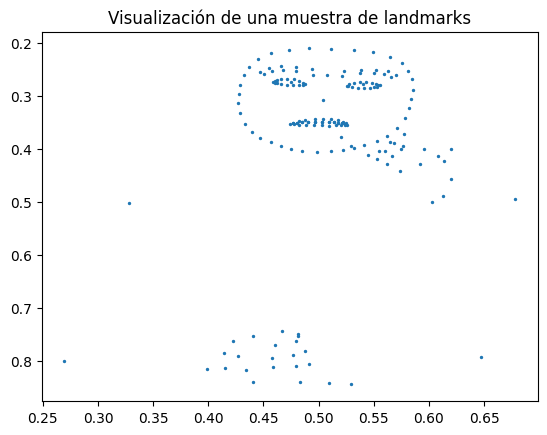

Tamaño del grupo 'landmarks': 14289
Tamaño del grupo 'embeddings': 14289
Tamaño del grupo 'words': 14289
Tamaño de una muestra de 'landmarks': (63, 180, 3)
Tamaño de una muestra de 'embeddings': (300,)
Muestra de 'embeddings':
[-0.03018166  0.11524644 -0.03263503  0.2848319  -0.00859523]
Muestra de 'words': last


In [21]:
zarr_path = "data/train_interpolated_v2.zarr"
result = inspect_zarr_groups(zarr_path, 4)

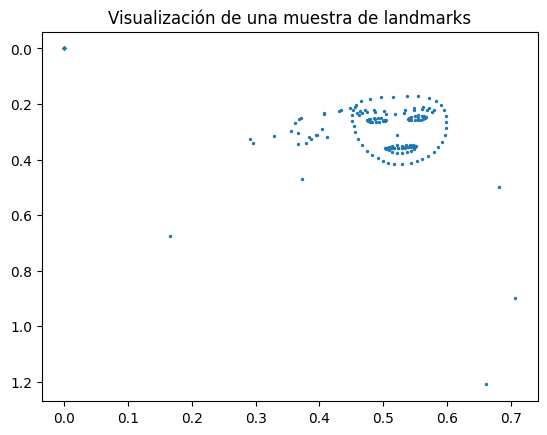

Tamaño del grupo 'landmarks': 14289
Tamaño del grupo 'embeddings': 14289
Tamaño del grupo 'words': 14289
Tamaño de una muestra de 'landmarks': (83, 180, 3)
Tamaño de una muestra de 'embeddings': (300,)
Muestra de 'embeddings':
[-0.00640969 -0.05264287 -0.0524165   0.0379969  -0.05410231]
Muestra de 'words': mexico


In [11]:
zarr_path = "data/train_data_v2.zarr"
result = inspect_zarr_groups(zarr_path, 5)

In [22]:
zarr_path = "data/train_interpolated_v2.zarr"
zarr_data = zarr.open_group(zarr_path, mode="r")

landmarks_group = zarr_data["landmarks"]

# Tamaño de una muestra
first_landmark_key = list(landmarks_group.keys())[4]

# Obtener una muestra
sample = landmarks_group[first_landmark_key][:]

generate_landmarks_comparison_video(sample)

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


In [20]:
zarr_path = "data/train_data_v2.zarr"
zarr_data = zarr.open_group(zarr_path, mode="r")

landmarks_group = zarr_data["landmarks"]

# Tamaño de una muestra
first_landmark_key = list(landmarks_group.keys())[5]

# Obtener una muestra
sample = landmarks_group[first_landmark_key][:]

generate_landmarks_comparison_video(sample)

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


### Data Aumentation

In [23]:
def process_augmentations(
    train_path,
    output_path,
    num_augmentations,
    rotation_axes,
    rotation_angles,
    zoom_factor,
    x_shift,
    y_shift,
    landmarks_group="landmarks",
    embeddings_group="embeddings",
    words_group="words",
):
    """
    Realiza aumentaciones de los landmarks y guarda los resultados, incluyendo embeddings y palabras como grupos, en un archivo Zarr.

    Args:
        train_path (str): Ruta al archivo Zarr de entrada.
        output_path (str): Ruta al archivo Zarr de salida.
        num_augmentations (int): Número de aumentaciones por secuencia.
        rotation_axes (list): Ejes de rotación (e.g., ['x', 'y', 'z']).
        rotation_angles (dict): Rango de ángulos de rotación para cada eje.
        zoom_factor (tuple): Rango de factores de zoom (e.g., (0.8, 1.4)).
        x_shift (tuple): Rango de desplazamiento en x.
        y_shift (tuple): Rango de desplazamiento en y.
        landmarks_group (str): Nombre del grupo de landmarks en el archivo Zarr.
        embeddings_group (str): Nombre del grupo de embeddings en el archivo Zarr.
        words_group (str): Nombre del grupo de palabras en el archivo Zarr.
    """
    # Cargar datos de entrada desde Zarr
    train_data = zarr.open_group(train_path, mode="r")
    landmarks = train_data[landmarks_group]
    embeddings = train_data[embeddings_group]
    words = train_data[words_group]

    # Crear archivo Zarr de salida
    output_data = zarr.open_group(output_path, mode="w")
    landmarks_out_group = output_data.create_group(landmarks_group)
    embeddings_out_group = output_data.create_group(embeddings_group)
    words_out_group = output_data.create_group(words_group)

    # Procesar cada secuencia
    for idx in tqdm(range(len(landmarks)), desc="Procesando y Guardando", unit="secuencia"):
        original_landmark = landmarks[str(idx)][...]  # Acceder al landmark original
        original_embedding = embeddings[str(idx)][...]  # Embedding correspondiente
        original_word = words[str(idx)][()]  # Palabra asociada

        # Generar aumentaciones
        augmented_versions = augmentation.augment_pipeline(
            original_landmark,
            num=num_augmentations,
            rotation_axes=rotation_axes,
            rotation_angles=rotation_angles,
            zoom_factor=zoom_factor,
            x_shift=x_shift,
            y_shift=y_shift
        )
        
        for aug_idx, augmented_landmark in enumerate(augmented_versions):
            # Nombres únicos para landmarks, embeddings y palabras
            landmark_name = f"{idx}_{aug_idx}"
            
            # Guardar landmarks aumentados
            landmarks_out_group.create_dataset(
                landmark_name,
                data=augmented_landmark,
                compressor=Blosc(cname="zstd", clevel=5, shuffle=Blosc.SHUFFLE),
            )
            
            # Guardar embeddings (se mantienen iguales)
            embeddings_out_group.create_dataset(
                landmark_name,
                data=original_embedding,
                compressor=Blosc(cname="zstd", clevel=5, shuffle=Blosc.SHUFFLE),
            )

            # Guardar palabras (se mantienen iguales)
            words_out_group.create_dataset(
                landmark_name,
                data=original_word,
                dtype="str",
                compressor=Blosc(cname="zstd", clevel=5, shuffle=Blosc.SHUFFLE),
            )

    print(f"Dataset aumentado guardado en: {output_path}")

In [24]:
# Parámetros de aumentación
rotation_axes = ['x', 'y', 'z']
rotation_angles = {
    'x': (-15, 15),
    'y': (-15, 15),
    'z': (-5, 5)
}
zoom_factor = (0.8, 1.4)
x_shift = (-0.15, 0.15)
y_shift = (-0.15, 0.15)

# Número de aumentaciones por secuencia
num_augmentations = 5
augmentation = DataAugmentor(HAND_NUM, POSE_NUM, default_config=rotation_angles)

In [25]:
# Rutas de los datos
train_path = "data/train_interpolated_v2.zarr"
output_path = "data/train_inter_augmented_5_v2.zarr"

# Procesar aumentaciones
process_augmentations(
    train_path=train_path,
    output_path=output_path,
    num_augmentations=num_augmentations,
    rotation_axes=rotation_axes,
    rotation_angles=rotation_angles,
    zoom_factor=zoom_factor,
    x_shift=x_shift,
    y_shift=y_shift,
    landmarks_group="landmarks",
    embeddings_group="embeddings"
)

Procesando y Guardando: 100%|██████| 14289/14289 [04:02<00:00, 58.86secuencia/s]

Dataset aumentado guardado en: data/train_inter_augmented_5_v2.zarr


In [ ]:
zarr_path = "data/train_inter_augmented_5_v2.zarr"
result = inspect_zarr_groups(zarr_path)

In [26]:
train_path = "data/train_data_v2.zarr"
output_path = "data/train_augmented_5_v2.zarr"

# Procesar aumentaciones
process_augmentations(
    train_path=train_path,
    output_path=output_path,
    num_augmentations=num_augmentations,
    rotation_axes=rotation_axes,
    rotation_angles=rotation_angles,
    zoom_factor=zoom_factor,
    x_shift=x_shift,
    y_shift=y_shift,
    landmarks_group="landmarks"
)

Procesando y Guardando: 100%|██████| 14289/14289 [03:55<00:00, 60.57secuencia/s]

Dataset aumentado guardado en: data/train_augmented_5_v2.zarr


In [ ]:
zarr_path = "data/train_augmented_5_v2.zarr"
result = inspect_zarr_groups(zarr_path)

### Normalization

In [27]:
def process_normalization(input_zarr_path, output_zarr_path, normalizer):
    """
    Procesa y normaliza los landmarks y guarda los resultados en un archivo Zarr, 
    incluyendo embeddings y palabras asociadas.

    Args:
        input_zarr_path (str): Ruta al archivo Zarr de entrada con datos aumentados.
        output_zarr_path (str): Ruta al archivo Zarr de salida.
        normalizer (LandmarkNormalizer): Instancia de la clase LandmarkNormalizer.
    """
    # Cargar datos de entrada
    input_data = zarr.open_group(input_zarr_path, mode="r")
    landmarks_group = input_data["landmarks"]
    embeddings_group = input_data["embeddings"]
    words_group = input_data["words"]

    # Crear archivo Zarr de salida
    output_data = zarr.open_group(output_zarr_path, mode="w")
    normalized_landmarks_group = output_data.require_group("landmarks")
    normalized_embeddings_group = output_data.require_group("embeddings")
    normalized_words_group = output_data.require_group("words")

    # Iterar sobre los datasets en el grupo de landmarks
    for key in tqdm(landmarks_group.keys(), desc="Normalizando datos"):
        # Leer los datos aumentados
        augmented_data = landmarks_group[key][...]

        # Verificar la forma esperada
        if augmented_data.ndim != 3 or augmented_data.shape[2] != 3:
            print(f"Advertencia: El dataset {key} no tiene la forma (frames, landmarks, 3). Se omite.")
            continue

        # Aplicar la normalización
        normalized_data = normalizer.normalize_sequence(augmented_data)

        if normalized_data is None:
            print(f"Advertencia: La secuencia {key} no pasó los criterios de normalización.")
            continue

        # Guardar los datos normalizados
        normalized_landmarks_group.create_dataset(
            key,
            data=normalized_data,
            compressor=Blosc(cname="zstd", clevel=5, shuffle=Blosc.SHUFFLE),
        )

        # Copiar los embeddings correspondientes directamente
        if key in embeddings_group:
            normalized_embeddings_group.create_dataset(
                key,
                data=embeddings_group[key][...],
                compressor=Blosc(cname="zstd", clevel=5, shuffle=Blosc.SHUFFLE),
            )
        else:
            print(f"Advertencia: No se encontró el embedding correspondiente para {key}.")

        # Copiar las palabras correspondientes directamente
        if key in words_group:
            normalized_words_group.create_dataset(
                key,
                data=words_group[key][()],
                dtype="str",
                compressor=Blosc(cname="zstd", clevel=5, shuffle=Blosc.SHUFFLE),
            )
        else:
            print(f"Advertencia: No se encontró la palabra correspondiente para {key}.")

    print(f"Datos normalizados guardados en: {output_zarr_path}")

In [28]:
indices = {
    "critical": [shoulder_left_idx, shoulder_right_idx, nose_idx],
    "shoulder_left": shoulder_left_idx,
    "shoulder_right": shoulder_right_idx,
    "nose": nose_idx,
    "left_eye": left_eye_idx,
    "right_eye": right_eye_idx,
    "left_wrist_pose": global_wrist_left_idx_pose,
    "right_wrist_pose": global_wrist_right_idx_pose,
    "left_hand": left_idx_hand,
    "right_hand": right_idx_hand
}

# Crear instancia del normalizador
normalizer = LandmarkNormalizer(indices=indices, threshold=0.5)

In [29]:
input_zarr_path = "data/train_data_v2.zarr"
output_zarr_path = "data/train_data_norm_v2.zarr"

# Procesar normalización
process_normalization(input_zarr_path, output_zarr_path, normalizer)

Normalizando datos: 100%|████████████████| 14289/14289 [01:14<00:00, 192.25it/s]

Datos normalizados guardados en: data/train_data_norm_v2.zarr


In [30]:
input_zarr_path = "data/train_interpolated_v2.zarr"
output_zarr_path = "data/train_inter_normalized_v2.zarr"

# Procesar normalización
process_normalization(input_zarr_path, output_zarr_path, normalizer)

Normalizando datos: 100%|████████████████| 14289/14289 [01:23<00:00, 171.44it/s]

Datos normalizados guardados en: data/train_inter_normalized_v2.zarr


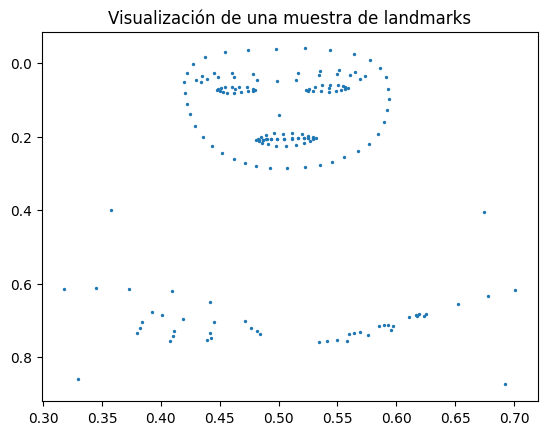

Tamaño del grupo 'landmarks': 14289
Tamaño del grupo 'embeddings': 14289
Tamaño del grupo 'words': 14289
Tamaño de una muestra de 'landmarks': (75, 180, 2)
Tamaño de una muestra de 'embeddings': (300,)
Muestra de 'embeddings':
[-0.12300604  0.10517146  0.03482125  0.11793281  0.11232583]
Muestra de 'words': book


In [21]:
zarr_path = "data/train_inter_normalized_v2.zarr"
result = inspect_zarr_groups(zarr_path)

In [31]:
input_zarr_path = "data/train_inter_augmented_5_v2.zarr"
output_zarr_path = "data/train_inter_augmented_5_norm_v2.zarr"

# Procesar normalización
process_normalization(input_zarr_path, output_zarr_path, normalizer)

Normalizando datos:   3%|▍                | 2374/85734 [00:09<05:22, 258.12it/s]

Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 10352_1 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 10352_2 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 10352_3 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 10352_4 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 10352_5 no pasó los criterios de normalización.


Normalizando datos:   9%|█▌               | 7900/85734 [00:33<04:04, 318.73it/s]

Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 11179_1 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 11179_2 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 11179_3 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 11179_4 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 11179_5 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 11184_1 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 11184_2 no p

Normalizando datos:  12%|█▉              | 10240/85734 [00:42<04:43, 266.44it/s]

Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 11529_1 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 11529_2 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 11529_3 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 11529_4 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 11529_5 no pasó los criterios de normalización.


Normalizando datos:  15%|██▍             | 12796/85734 [00:52<04:38, 262.06it/s]

Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 11914_1 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 11914_2 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 11914_3 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 11914_4 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 11914_5 no pasó los criterios de normalización.


Normalizando datos:  25%|████            | 21687/85734 [01:29<04:09, 256.64it/s]

Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 1324_1 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 1324_2 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 1324_3 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 1324_4 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 1324_5 no pasó los criterios de normalización.


Normalizando datos:  27%|████▎           | 23002/85734 [01:34<03:59, 261.88it/s]

Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 13448_1 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 13448_2 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 13448_3 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 13448_4 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 13448_5 no pasó los criterios de normalización.


Normalizando datos:  35%|█████▌          | 29905/85734 [02:02<03:13, 288.61it/s]

Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 1618_1 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 1618_2 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 1618_3 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 1618_4 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 1618_5 no pasó los criterios de normalización.


Normalizando datos:  37%|█████▉          | 31574/85734 [02:09<03:23, 266.49it/s]

Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 186_1 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 186_2 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 186_3 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 186_4 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 186_5 no pasó los criterios de normalización.


Normalizando datos:  37%|█████▉          | 31789/85734 [02:10<03:20, 268.97it/s]

Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 1904_1 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 1904_2 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 1904_3 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 1904_4 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 1904_5 no pasó los criterios de normalización.


Normalizando datos:  39%|██████▏         | 33245/85734 [02:15<02:49, 308.99it/s]

Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 2120_1 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 2120_2 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 2120_3 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 2120_4 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 2120_5 no pasó los criterios de normalización.


Normalizando datos:  47%|███████▌        | 40224/85734 [02:45<03:06, 244.58it/s]

Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 316_1 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 316_2 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 316_3 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 316_4 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 316_5 no pasó los criterios de normalización.


Normalizando datos:  69%|███████████     | 59295/85734 [04:01<01:42, 258.55it/s]

Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 6028_1 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 6028_2 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 6028_3 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 6028_4 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 6028_5 no pasó los criterios de normalización.


Normalizando datos:  78%|████████████▍   | 66606/85734 [04:30<01:15, 254.75it/s]

Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 7124_1 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 7124_2 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 7124_3 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 7124_4 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 7124_5 no pasó los criterios de normalización.


Normalizando datos:  84%|█████████████▍  | 71813/85734 [04:51<00:49, 283.42it/s]

Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 7909_1 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 7909_2 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 7909_3 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 7909_4 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 7909_5 no pasó los criterios de normalización.


Normalizando datos:  88%|██████████████  | 75651/85734 [05:07<00:34, 294.02it/s]

Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 8479_1 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 8479_2 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 8479_3 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 8479_4 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 8479_5 no pasó los criterios de normalización.


Normalizando datos:  91%|██████████████▌ | 77950/85734 [05:16<00:29, 266.77it/s]

Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 8827_1 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 8827_2 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 8827_3 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 8827_4 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 8827_5 no pasó los criterios de normalización.


Normalizando datos:  95%|███████████████▎| 81820/85734 [05:32<00:13, 290.53it/s]

Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 9411_1 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 9411_2 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 9411_3 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 9411_4 no pasó los criterios de normalización.
Secuencia descartada: demasiados valores faltantes en landmarks críticos.
Advertencia: La secuencia 9411_5 no pasó los criterios de normalización.


Normalizando datos: 100%|████████████████| 85734/85734 [05:49<00:00, 245.56it/s]

Datos normalizados guardados en: data/train_inter_augmented_5_norm_v2.zarr
